In [1]:
from agent.scrape import scrape_sklearn_website

data = scrape_sklearn_website()

100%|██████████| 40/40 [03:11<00:00,  5.39s/it]

In [1]:
import json

with open("data/sklearn_function_openai.json","r") as jsonfile:
    function_calling_data = json.load(jsonfile)

In [2]:
import networkx as nx

sklearn_graph = nx.DiGraph()

parent_names = [
        (function_calling_data[d]["name"], {"url": function_calling_data[d]["url"], "type": "parent_node"}) for d in function_calling_data
    ]

In [3]:
function_calling_data.keys()

dict_keys(['sklearn.html', 'sklearn.base.html', 'sklearn.calibration.html', 'sklearn.cluster.html', 'sklearn.compose.html', 'sklearn.covariance.html', 'sklearn.cross_decomposition.html', 'sklearn.datasets.html', 'sklearn.decomposition.html', 'sklearn.discriminant_analysis.html', 'sklearn.dummy.html', 'sklearn.ensemble.html', 'sklearn.exceptions.html', 'sklearn.experimental.html', 'sklearn.feature_extraction.html', 'sklearn.feature_selection.html', 'sklearn.gaussian_process.html', 'sklearn.impute.html', 'sklearn.inspection.html', 'sklearn.isotonic.html', 'sklearn.kernel_approximation.html', 'sklearn.kernel_ridge.html', 'sklearn.linear_model.html', 'sklearn.manifold.html', 'sklearn.metrics.html', 'sklearn.mixture.html', 'sklearn.model_selection.html', 'sklearn.multiclass.html', 'sklearn.multioutput.html', 'sklearn.naive_bayes.html', 'sklearn.neighbors.html', 'sklearn.neural_network.html', 'sklearn.pipeline.html', 'sklearn.preprocessing.html', 'sklearn.random_projection.html', 'sklearn.se

In [4]:
num_words = []
# def return_max():
for parent in function_calling_data:
   parent_data = function_calling_data[parent]
   parent_name = parent_data['name']
   for sub_level in parent_data["functions"]:
      for sub_level_name,sub_level_funcs in sub_level.items():
         for funcs in sub_level_funcs:
            function_text = funcs['function_definitions']['function_text']
            function_text = function_text.replace("\n\n"," ")
            function_text = function_text.replace("\n"," ")
            word_len = len(function_text.split(" "))
               # if word_len>=2000:
               #    return funcs
            num_words.append(len(function_text.split(" ")))
         

In [5]:
max(num_words)

546

100%|██████████| 40/40 [02:56<00:00,  4.41s/it]


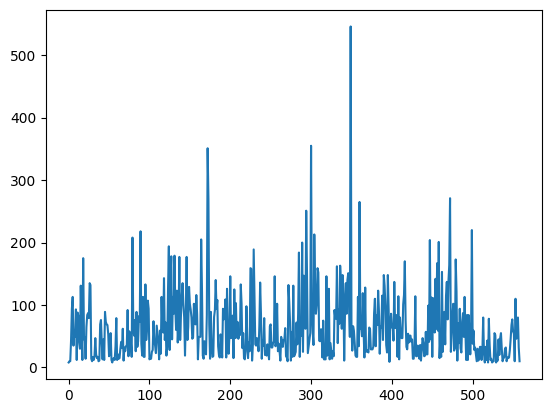

In [8]:
import matplotlib.pyplot as plt
plt.plot(num_words)

In [30]:
import requests
from bs4 import BeautifulSoup

func_url = "https://scikit-learn.org/stable/modules/generated/sklearn.utils.discovery.all_displays.html#all-displays"
func_response = requests.get(func_url)
func_soup = BeautifulSoup(
    func_response.content, "lxml", from_encoding="utf-8"
)

func_name = func_soup.find("h1").text.replace("#", "")  # remove #
elem = func_soup.find(attrs={"class": "sig sig-object py"})
full_function = elem.text.replace("[source]#", "").replace("\n", "")

In [31]:
func_text = func_soup.find("dd").find_all("p")

In [34]:
results = []
for element in func_soup.find_all(True):
    if 'field-list' in element.get('class', []):
        break
    if element.name == 'p':
        results.append(element.text)

In [35]:
results

['Section Navigation', 'Get a list of all displays from sklearn.']

<BarContainer object of 559 artists>

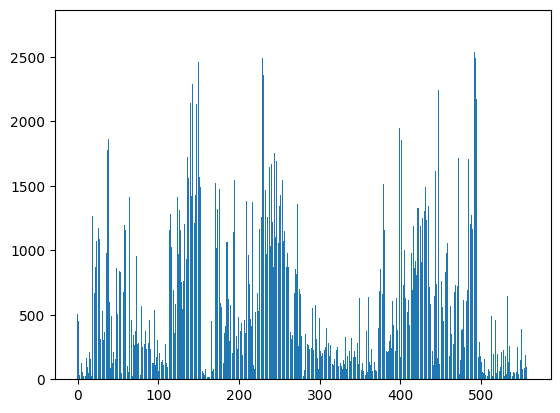

In [10]:
import matplotlib.pyplot as plt

plt.bar([i for i in range(len(num_words))],num_words)

In [11]:
len(num_words)

559

## SUMMARY

In [5]:
docs = []
metadata = []

for parent in function_calling_data:
    parent_data = function_calling_data[parent]
    parent_name = parent_data['name']
    for sub_level in parent_data["functions"]:
        for sub_level_name,sub_level_funcs in sub_level.items():
            # defaults --> function definitions
            for funcs in sub_level_funcs:
                function_text = funcs['function_definitions']['function_text']
                function_text = function_text.replace("\n\n"," ")
                function_text = function_text.replace("\n"," ")
                function_text= function_text.replace("Examples"," ")
                docs.append(
                    function_text
                )
                metadata.append(
                    {
                        "function_name": funcs['func_name'],
                        "function_url": funcs['func_url'],
                        "full_function": funcs['function_definitions']['full_function'],
                        "function_calling": str(funcs['function_calling']),
                        "parent": parent_name,
                        "sub_level_name":sub_level_name,
                        "sub_level_trail": parent_name,
                        "function_trail":f"{parent_name}-->{sub_level_name}" 
                    }
                )

In [6]:
len(docs),len(metadata)

(559, 559)

In [1]:
from agent.database import build_database,load_database
from dotenv import load_dotenv,find_dotenv
import os

load_dotenv(find_dotenv(),override=True)
# build_database(docs,metadata,os.environ['OPENAI_API_KEY'])

True

In [2]:
sklearn_collection = load_database(os.environ['OPENAI_API_KEY'])

In [30]:
import dspy
import chromadb.utils.embedding_functions as embedding_functions
import os
from agent.utils import *
import yaml

with open("config.yaml") as stream:
    try:
        config_params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
load_dotenv(find_dotenv(), override=True)

class FirstSecondLevel(dspy.Signature):
    """You are given a list of keys and their corresponding description separated by semicolon in the format keys: description.
    Based on the query, you have to classify the question to one of the key or keys that is relevant to the question.
    Be precise and output only the relevant key or keys and don't output their descriptions.
    Don't include any other information and DON'T answer None or N/A"""

    query = dspy.InputField(prefix="Query which you need to classify: ", format=str)
    keys_values = dspy.InputField(prefix="Keys and Values: ", format=str)
    output = dspy.OutputField(
        prefix="Relevant Key(s): ",
        format=str,
        desc="relevant keys separated by semicolon",
    )


emb_fn = embedding_functions.OpenAIEmbeddingFunction(
    api_key=os.environ["OPENAI_API_KEY"],
    model_name=config_params["VECTORDB"]["EMBEDDING_MODEL_NAME"],
)

llm = dspy.OpenAI(model=config_params['LEVEL_NODE_LLM']['OPENAI_LLM_MODEL'],max_tokens=512)
dspy.settings.configure(lm=llm)
class SklearnAgentChroma(dspy.Module):
    def __init__(self, collection):
        super().__init__()
        self.collection = collection
        self.firstSecondLevel = dspy.Predict(FirstSecondLevel)

    def __call__(self, *args, **kwargs):
        return super().__call__(*args, **kwargs)

    def forward(self, query: str):
        query_emb = emb_fn([query])[0]

        # Parent level querying
        parent_level = self.collection.query(
            query_embeddings=query_emb,
            n_results=3,
        )
        parent_level_str = ""
        for parent_level_docs,parent_level_metadata in zip(parent_level['documents'][0],parent_level["metadatas"][0]):
            if parent_level_docs in parent_level_str: continue
            parent_level_str += f"{parent_level_metadata['parent']}: {parent_level_docs}\n\n"

        parent_level_answer = self.firstSecondLevel(
            query=query, keys_values=parent_level_str
        ).output
        print(parent_level_str, parent_level_answer)
        trail_list = parent_level_answer.split(";")
        trail_list = list(set(trail_list))
        trail_list_pairs = generate_pairs_recursive([trail_list])

        trail_where_clause = get_trail_list_pairs(trail_list_pairs,"sub_level_trail")

        sub_level = self.collection.query(
            query_embeddings=query_emb,
            where=trail_where_clause,
            n_results=3,
        )

        sub_level_str = ""
        for sub_level_docs,function_level_metadata in zip(sub_level['documents'][0],sub_level["metadatas"][0]):
            if sub_level_docs in sub_level_str: continue
            sub_level_str += f"{function_level_metadata['parent']}#{function_level_metadata['sub_level_name']}: {sub_level_docs}\n\n"
        print(sub_level_str)
        sub_level_answer = self.firstSecondLevel(
            query=query, keys_values=sub_level_str
        ).output
        print(sub_level_answer)
        sub_level_list = sub_level_answer.split(";")
        sub_level_list = [sbl.split("#")[-1] for sbl in sub_level_list]
        sub_level_list = list(set(sub_level_list))
        function_list = generate_pairs_recursive([trail_list_pairs,sub_level_list])
        function_where_clause = get_trail_list_pairs(function_list,'function_trail')
        print(function_where_clause)
        functions = self.collection.query(
            query_embeddings=query_emb,
            where=function_where_clause,
            n_results=1
        )
        return functions['metadatas'][0]

In [5]:
from agent.dspy_agent import SklearnAgentChroma
sklearn_chroma = SklearnAgentChroma(sklearn_collection)

In [7]:
sklearn_chroma("How can I handle missing values in my dataset using scikit-learn")

sklearn.impute: Section Navigation Univariate imputer for completing missing values with simple strategies. Replace missing values using a descriptive statistic (e.g. mean, median, or most frequent) along each column, or using a constant value. Read more in the User Guide. Added in version 0.20: SimpleImputer replaces the previous sklearn.preprocessing.Imputer estimator which is now removed.

sklearn.impute: Section Navigation Imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close. Read more in the User Guide. Added in version 0.22.

sklearn.metrics: Section Navigation Calculate the euclidean distances in the presence of missing values. Compute the euclidean distance between each pair of samples in X and Y, where Y=X is assumed if Y=None. When calculating the distance between a pa

[{'full_function': "class sklearn.impute.SimpleImputer(*, missing_values=nan, strategy='mean', fill_value=None, copy=True, add_indicator=False, keep_empty_features=False)",
  'function_calling': "{'name': 'SimpleImputer', 'descriptions': 'Section Navigation Univariate imputer for completing missing values with simple strategies. Replace missing values using a descriptive statistic (e.g. mean, median, or\\nmost frequent) along each column, or using a constant value. Read more in the User Guide. Added in version 0.20: SimpleImputer replaces the previous sklearn.preprocessing.Imputer\\nestimator which is now removed.', 'parameters': {'type': 'object', 'properties': {'X': {'type': 'array', 'description': '{array-like, sparse matrix}, shape (n_samples, n_features). The input data to complete.\\n'}}, 'required': []}}",
  'function_name': 'SimpleImputer',
  'function_trail': 'sklearn.impute-->defaults',
  'function_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.impute.Simple

In [33]:
sklearn_chroma("How to do linear regression in an unbalanced dataset?")

sklearn.utils: Section Navigation Estimate sample weights by class for unbalanced datasets.

sklearn.utils: Section Navigation Estimate class weights for unbalanced datasets.

sklearn.datasets: Section Navigation Generate a random regression problem with sparse uncorrelated design. This dataset is described in Celeux et al [1]. as: Only the first 4 features are informative. The remaining features are useless. Read more in the User Guide.

 sklearn.utils
sklearn.utils#Weight handling based on class labels: Section Navigation Estimate sample weights by class for unbalanced datasets.

sklearn.utils#Weight handling based on class labels: Section Navigation Estimate class weights for unbalanced datasets.

sklearn.utils#defaults: Section Navigation Resample arrays or sparse matrices in a consistent way. The default strategy implements one step of the bootstrapping procedure.


sklearn.utils#Weight handling based on class labels; sklearn.utils#defaults
{'$or': [{'function_trail': {'$eq': 'skl

[{'full_function': 'sklearn.utils.class_weight.compute_sample_weight(class_weight, y, *, indices=None)',
  'function_calling': '{\'name\': \'compute_sample_weight\', \'descriptions\': \'Section Navigation Estimate sample weights by class for unbalanced datasets.\', \'parameters\': {\'type\': \'object\', \'properties\': {\'class_weight\': {\'type\': \'array\', \'description\': \'dict, list of dicts, “balanced”, or None. Weights associated with classes in the form {class_label: weight}.\\nIf not given, all classes are supposed to have weight one. For\\nmulti-output problems, a list of dicts can be provided in the same\\norder as the columns of y.\\nNote that for multioutput (including multilabel) weights should be\\ndefined for each class of every column in its own dict. For example,\\nfor four-class multilabel classification weights should be\\n[{0: 1, 1: 1}, {0: 1, 1: 5}, {0: 1, 1: 1}, {0: 1, 1: 1}] instead of\\n[{1:1}, {2:5}, {3:1}, {4:1}].\\nThe "balanced" mode uses the values of y t